In [1]:
#import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from reference_converters import *

In [2]:
# loading data 
compound_table = pd.read_parquet('compound_table.parquet')
compound_table.sort_values('id', ascending=True, inplace=True)
compound_table.rename(columns={'id': 'compound_id'}, inplace=True)
electrochem_table = pd.read_parquet('electrochem_table.parquet')


In [3]:
# creating merged table
combined_table = compound_table.merge(electrochem_table, how='right', on='compound_id')
combined_table.dropna(subset=['name',], axis=0, inplace=True)
combined_table= combined_table[['compound_id', 'name', 'formula', 'recyclable', 'type', 'compound_family',
       'id', 'redox_potential_V', 'reference_electrode',
       'electrolyte', 'solvent', 'pH', 'used_in_photocat', 'used_in_rfbs', 'used_as_hcarrier', 'used_in_DSSC', 'measurement_ref'
       ]]

In [4]:
# data cleaning

# checking category binary
combined_table.loc[combined_table.used_in_photocat!=1, 'used_in_photocat'] = 0

# splitting aqueous non-aqueous
combined_table['aqueous'] = 0
combined_table.loc[combined_table.solvent=='water', 'aqueous']=1
combined_table.loc[combined_table.solvent=='aqueous', 'aqueous']=1


In [5]:
print(f"Table contains data for {combined_table.compound_id.nunique()} compounds:")
print(f"compound_family: {combined_table.compound_family.nunique()} distinct")
print(f"type: {combined_table.type.nunique()} distinct")
print(f"solvent: {combined_table.solvent.nunique()} distinct")
print(f"{combined_table.loc[combined_table.aqueous==1, 'compound_id'].nunique()} compounds with redox potentials measured in aqueous media")

Table contains data for 45 compounds:
compound_family: 12 distinct
type: 3 distinct
solvent: 12 distinct
17 compounds with redox potentials measured in aqueous media


In [6]:
display(combined_table[['compound_family', 'type', 'compound_id', 'id']].groupby(['type', 'compound_family']).nunique())

compound_id  id
type              compound_family                    
electron acceptor dialkylquinoxaline            1   2
                  viologen                      3   3
electron donor    R-NADH                        2   5
                  TEMPO                         2   2
                  acridine                      1   1
                  amine                         6   6
                  benzimidazole                 9  10
                  dialkoxybenzene               3   4
                  disulfide forming             8   8
                  ferrocene                     3   3
                  quinone                       3   4
photosensitizer   organometallic                4  18

In [7]:
# setting aqueous data to one reference redox potentials
print(combined_table.loc[combined_table.aqueous==1,'reference_electrode'].unique())
print(combined_table.loc[combined_table.aqueous==1,'pH'].unique())

['SCE' 'NHE' 'SHE' 'Ag|AgCl']
[nan 7.  0.  0.7 8.2 4.6]


In [8]:
print(combined_table.loc[combined_table.aqueous!=1,'reference_electrode'].unique())

['SCE' 'SHE' 'Li|Li+' 'Fc/Fc+' 'NHE' 'Ag|AgCl']


In [9]:
print(combined_table.loc[combined_table.reference_electrode=='Li|Li+', 'solvent'].unique())

['EC/PC/EMC' 'PC' 'EC/EMC' 'PEC']


In [10]:
print(combined_table.loc[combined_table.aqueous!=1, 'solvent'].unique())

['acetonitrile' 'THF' 'EC/PC/EMC' 'PC' 'EC/EMC' 'PEC' 'MeCN' 'DMF' 'DMSO'
 'gamma-butyrolactone']


In [11]:
display(combined_table.sort_values('compound_id'))

,compound_id,name,formula,recyclable,type,compound_family,id,redox_potential_V,reference_electrode,electrolyte,solvent,pH,used_in_photocat,used_in_rfbs,used_as_hcarrier,used_in_DSSC,measurement_ref,aqueous
0,1,triethylamine,(C2H5)3N,0.0,electron donor,amine,1,0.690,SCE,,water,NaN,1.0,0.0,0.0,0.0,https://doi.org/10.1016/j.crci.2015.11.026,1
1,2,triethanolamine,(HOCH2CH2)3N,0.0,electron donor,amine,2,1.070,NHE,pH7 phosphate buffer,water,7.0,1.0,0.0,0.0,0.0,https://doi.org/10.1039/c3cp55023k,1
31,4,4-dimethylaminotoluene (DMT),CH3C6H4N(CH3)2,0.0,electron donor,amine,32,0.700,SCE,TBAClO4,MeCN,NaN,1.0,0.0,0.0,0.0,https://doi.org/10.1016/S0022-0728(70)80304-7,0
4,5,"1,3-dimethyl-2-phenylbenzimidazoline (BIH)",C15H16N2,0.0,electron donor,benzimidazole,5,0.330,SCE,Et4NClO4,acetonitrile,NaN,1.0,0.0,0.0,0.0,doi:10.1016/j.tet.2006.03.061,0
50,5,"1,3-dimethyl-2-phenylbenzimidazoline (BIH)",C15H16N2,0.0,electron donor,benzimidazole,51,-0.440,Fc/Fc+,,DMSO,NaN,1.0,0.0,0.0,0.0,DOI: 10.1039/C9CC00928K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,50,4-methoxyphenylthioate,[C8H7OS2]-,0.0,electron donor,disulfide forming,63,0.190,SCE,,acetonitrile,NaN,1.0,0.0,0.0,0.0,DOI: 10.1016/j.crci.2015.11.026,0
63,51,"1-Benzyl-1,4-dihydronicotinamide (BNAH)",C13H14N2O,1.0,electron donor,R-NADH,64,0.480,NHE,unspecified buffer,aqueous,8.2,1.0,0.0,0.0,0.0,DOI: 10.1016/0302-4598(74)85011-7,1
64,51,"1-Benzyl-1,4-dihydronicotinamide (BNAH)",C13H14N2O,1.0,electron donor,R-NADH,65,0.660,NHE,unspecified buffer,aqueous,8.2,1.0,0.0,0.0,0.0,DOI: 10.1016/0302-4598(74)85011-7,1
65,51,"1-Benzyl-1,4-dihydronicotinamide (BNAH)",C13H14N2O,1.0,electron donor,R-NADH,66,1.075,NHE,unspecified buffer,aqueous,4.6,1.0,0.0,0.0,0.0,DOI: 10.1016/0302-4598(74)85011-7,1


In [12]:
# converting potentials to vs. SCE for aqueous measurments
combined_table.loc[combined_table.aqueous==1,:] = combined_table.loc[combined_table.aqueous==1,:].apply(lambda row: aqueous_potentials_to_SCE(row), axis=1)
# converting potentials to vs. Fc/Fc+ for nonaqueous measurments
combined_table.loc[combined_table.aqueous!=1,:] = combined_table.loc[combined_table.aqueous!=1,:].apply(lambda row: nonaqueous_potentials_to_Fc(row), axis=1)

In [13]:
# split photosensitizers into a different table
ps_table = combined_table.loc[combined_table.type=='photosensitizer', :].copy(deep=True)
rsd_table = combined_table.loc[combined_table.type!='photosensitizer', :].copy(deep=True)

In [14]:
display(rsd_table[['compound_family', 'compound_id', 'aqueous', 'used_in_photocat', 'used_in_rfbs', 'used_as_hcarrier', 'used_in_DSSC']].groupby(['aqueous', 'compound_family','used_in_photocat', 'used_in_rfbs', 'used_as_hcarrier', 'used_in_DSSC']).nunique())

compound_id
aqueous compound_family    used_in_photocat used_in_rfbs used_as_hcarrier used_in_DSSC             
0       acridine           1.0              0.0          0.0              0.0                     1
        amine              0.0              0.0          0.0              0.0                     1
                                                         1.0              0.0                     1
                           1.0              0.0          0.0              0.0                     1
        benzimidazole      1.0              0.0          0.0              0.0                     9
        dialkoxybenzene    0.0              1.0          0.0              0.0                     3
        dialkylquinoxaline 0.0              1.0          0.0              0.0                     1
        disulfide forming  0.0              0.0          0.0              1.0                     5
                           1.0              0.0          0.0              0.0                     3
        quinone            0.0              0.0          1.0              0.0                     1
1       R-NADH             1.0              0.0          0.0              0.0                     2
        TEMPO              0.0              1.0          0.0              0.0                     2
        amine              1.0              0.0          0.0              0.0                     3
        ferrocene          0.0              1.0          0.0              0.0                     3
        quinone            0.0              0.0          1.0              0.0                     2
                                            1.0          1.0              0.0                     1
        viologen           0.0              1.0          0.0              0.0                     3

In [15]:
def label_function(row):
    label_tuple = (row.at['used_in_photocat'], row.at['recyclable'], row.at['used_in_rfbs'], row.at['used_as_hcarrier'], row.at['used_in_DSSC'])
    match label_tuple:
        case (1, 1, 0, 0, 0):
            label_text = 'recyclable donor'
        case (1, 0, 0, 0, _):
            label_text = 'sacrificial donor'
        case (0, _, 1, 0, 0):
            label_text = 'RFB redox couple'
        case (0, _, _, 1, _):
            label_text = 'hydrogen carrier'
        case (0, _, 0, 0, 1):
            label_text = 'DSSC redox couple'
        case _:
            label_text = 'electrochemistry only'
    row.at['label'] = label_text
    return row

In [16]:
rsd_table['label'] = ''
rsd_table = rsd_table.apply(lambda row: label_function(row), axis=1)

In [17]:
rsd_table.label.unique()

array(['sacrificial donor', 'recyclable donor', 'RFB redox couple',
       'hydrogen carrier', 'electrochemistry only', 'DSSC redox couple'],
      dtype=object)

In [18]:
ps_table['redox_event'] = ''
ps_table.loc[ps_table.id.isin([33, 48]), 'redox_event'] = 'Ered'
ps_table.loc[ps_table.id.isin([34, 50, 55, 42]), 'redox_event'] = 'Ered*'
ps_table.loc[ps_table.id.isin([35, 47, 54, 39]), 'redox_event'] = 'Eox'
ps_table.loc[ps_table.id.isin([36, 49, 56]), 'redox_event'] = 'Eox*'
#display(ps_table)

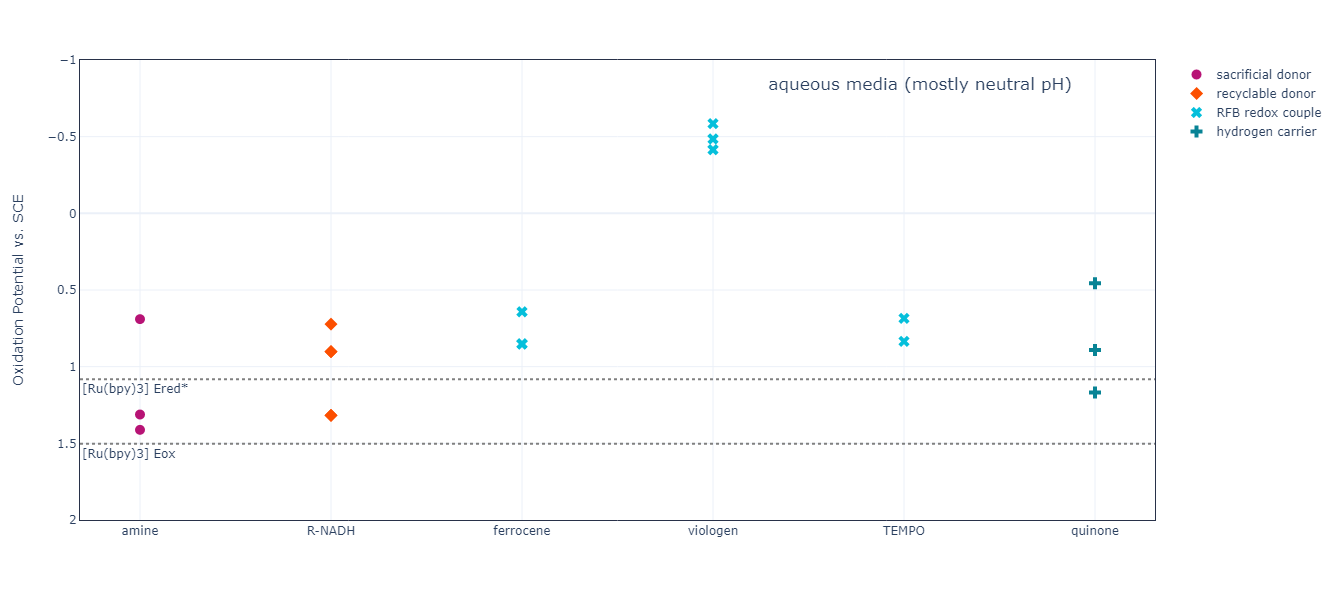

In [32]:
aqueous = px.scatter(rsd_table.loc[rsd_table.aqueous==1,:], x='compound_family', y='redox_potential_V', symbol='label', color='label',
                     color_discrete_sequence= ['#B71375', '#FC4F00', '#00FFCA', '#05BFDB', '#088395', '#0A4D68', '#2E4F4F'],
                     category_orders={'label':['sacrificial donor', 'recyclable donor', '', 'RFB redox couple', 'hydrogen carrier', 'DSSC redox couple', 'electrochemistry only']},
                     hover_data=dict(
                         name=True,
                         compound_id=True,
                         pH=True,
                         redox_potential_V=True,
                         used_in_photocat=True,
                         used_in_DSSC=True,
                         used_in_rfbs=True
                     ))
aqueous.update_traces(marker=dict(size=10))
aqueous.update_layout(legend=dict(title=''))
aqueous.update_yaxes(title='Oxidation Potential vs. SCE', range=[2,-1], linecolor='#283149', mirror=True)
aqueous.update_xaxes(title='', linecolor='#283149', mirror=True)
aqueous.update_layout(title="aqueous media (mostly neutral pH)", title_x=0.8, title_y=0.87, template='plotly_white', width=900, height=600)

id_list = ps_table.loc[(ps_table.compound_id==36)&(ps_table.aqueous==1),:].id.to_list()
id_list = [idnum for idnum in id_list if 'red*' in ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item() or ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item()=='Eox']
for idnum in id_list:
    aqueous.add_hline(y=ps_table.loc[ps_table.id==idnum, 'redox_potential_V'].values.item(),
                      line = dict(dash='dot', color='grey'),
                      annotation_text=f"[Ru(bpy)3] {ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item()}",
                      annotation_position="bottom left"
                     )
aqueous.show()

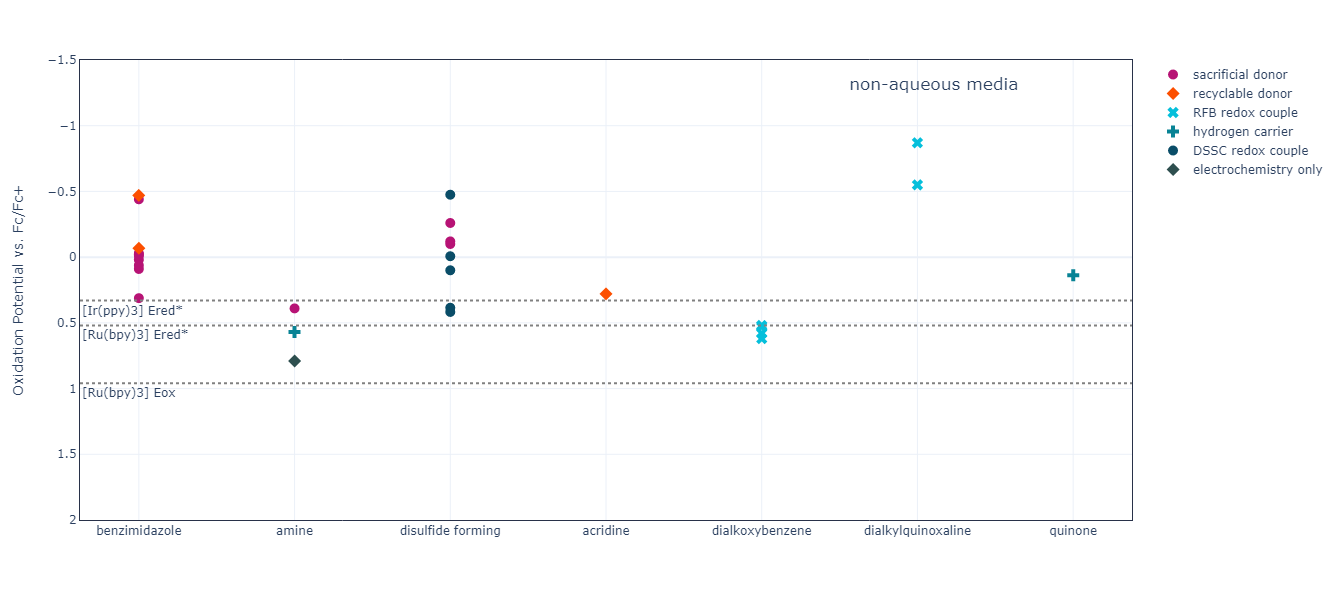

In [33]:
 aqueous = px.scatter(rsd_table.loc[rsd_table.aqueous!=1,:], x='compound_family', y='redox_potential_V', symbol='label', color='label',
                      color_discrete_sequence= ['#B71375', '#FC4F00', '#00FFCA', '#05BFDB', '#088395', '#0A4D68', '#2E4F4F'],
                     category_orders={'label':['sacrificial donor', 'recyclable donor', '', 'RFB redox couple', 'hydrogen carrier', 'DSSC redox couple', 'electrochemistry only']},
                     hover_data=dict(
                         compound_id=True,
                         name=True,
                         redox_potential_V=True,
                         used_in_photocat=True,
                         used_in_DSSC=True,
                         used_in_rfbs=True,
                         used_as_hcarrier=True,
                     ))
aqueous.update_traces(marker=dict(size=10))
aqueous.update_layout(legend=dict(title=''))
aqueous.update_yaxes(title='Oxidation Potential vs. Fc/Fc+', range=[2,-1.5], linecolor='#283149', mirror=True)
aqueous.update_xaxes(title='', linecolor='#283149', mirror=True)
aqueous.update_layout(title="non-aqueous media", title_x=0.76, title_y=0.87, template='plotly_white', width=900, height=600)

id_list = ps_table.loc[(ps_table.compound_id==36)&(ps_table.aqueous!=1),:].id.to_list()
id_list = [idnum for idnum in id_list if 'red*' in ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item() or ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item()=='Eox']
for idnum in id_list:
    aqueous.add_hline(y=ps_table.loc[ps_table.id==idnum, 'redox_potential_V'].values.item(),
                      line = dict(dash='dot', color='grey'),
                      annotation_text=f"[Ru(bpy)3] {ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item()}",
                      annotation_position="bottom left"
                     )
id_list = ps_table.loc[(ps_table.compound_id==44)&(ps_table.aqueous!=1),:].id.to_list()
id_list = [idnum for idnum in id_list if ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item()=='Ered*' or ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item()=='Eox']
for idnum in id_list:
    aqueous.add_hline(y=ps_table.loc[ps_table.id==idnum, 'redox_potential_V'].values.item(),
                      line = dict(dash='dot', color='grey'),
                      annotation_text=f"[Ir(ppy)3] {ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item()}",
                      annotation_position="bottom left"
                     )
# id_list = ps_table.loc[(ps_table.compound_id==38)&(ps_table.aqueous!=1),:].id.to_list()
# id_list = [idnum for idnum in id_list if ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item()=='Ered*' or ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item()=='Eox']
# for idnum in id_list:
#     aqueous.add_hline(y=ps_table.loc[ps_table.id==idnum, 'redox_potential_V'].values.item(),
#                       line = dict(dash='dot', color='grey'),
#                       annotation_text=f"[Cu(dpp)] {ps_table.loc[ps_table.id==idnum, 'redox_event'].values.item()}",
#                       annotation_position="top left"
#                      )
aqueous.show()

In [21]:
display(ps_table)

,compound_id,name,formula,recyclable,type,compound_family,id,redox_potential_V,reference_electrode,electrolyte,solvent,pH,used_in_photocat,used_in_rfbs,used_as_hcarrier,used_in_DSSC,measurement_ref,aqueous,redox_event
32,36,"[Ru(bpy)3]2+ Tris(2,2-bipyridyl)ruthenium(II)...",C30H36Cl2N6O6Ru,1.0,photosensitizer,organometallic,33,-1.038,SCE,,water,NaN,1.0,0.0,0.0,0.0,Balzani book page 199,1,Ered
33,36,"[Ru(bpy)3]2+ Tris(2,2-bipyridyl)ruthenium(II)...",C30H36Cl2N6O6Ru,1.0,photosensitizer,organometallic,34,1.082,SCE,,water,NaN,1.0,0.0,0.0,0.0,Balzani book page 199,1,Ered*
34,36,"[Ru(bpy)3]2+ Tris(2,2-bipyridyl)ruthenium(II)...",C30H36Cl2N6O6Ru,1.0,photosensitizer,organometallic,35,1.502,SCE,,water,NaN,1.0,0.0,0.0,0.0,Balzani book page 199,1,Eox
35,36,"[Ru(bpy)3]2+ Tris(2,2-bipyridyl)ruthenium(II)...",C30H36Cl2N6O6Ru,1.0,photosensitizer,organometallic,36,-0.618,SCE,,water,NaN,1.0,0.0,0.0,0.0,Balzani book page 199,1,Eox*
36,37,[Ir(tpy)3]3+,,1.0,photosensitizer,organometallic,37,-1.080,Fc/Fc+,,acetonitrile,NaN,1.0,0.0,0.0,0.0,Balzani book page 199,0,
37,37,[Ir(tpy)3]3+,,1.0,photosensitizer,organometallic,38,-0.610,Fc/Fc+,,acetonitrile,NaN,1.0,0.0,0.0,0.0,Balzani book page 199,0,
38,37,[Ir(tpy)3]3+,,1.0,photosensitizer,organometallic,39,1.630,Fc/Fc+,,acetonitrile,NaN,1.0,0.0,0.0,0.0,Balzani book page 199,0,Eox
39,38,[Cu(dpp)]+,,1.0,photosensitizer,organometallic,40,0.380,Fc/Fc+,,acetonitrile,NaN,1.0,0.0,0.0,0.0,Balzani book page 199,0,
40,38,[Cu(dpp)]+,,1.0,photosensitizer,organometallic,41,-1.990,Fc/Fc+,,acetonitrile,NaN,1.0,0.0,0.0,0.0,Balzani book page 199,0,
41,38,[Cu(dpp)]+,,1.0,photosensitizer,organometallic,42,-1.420,Fc/Fc+,,acetonitrile,NaN,1.0,0.0,0.0,0.0,Balzani book page 199,0,Ered*


In [22]:
display(rsd_table.loc[rsd_table.compound_id==22,:])

,compound_id,name,formula,recyclable,type,compound_family,id,redox_potential_V,reference_electrode,electrolyte,solvent,pH,used_in_photocat,used_in_rfbs,used_as_hcarrier,used_in_DSSC,measurement_ref,aqueous,label
15,22,"2,7-anthraquinonedisulfonic acid (AQDS)",C14H8O8S2,1.0,electron donor,quinone,16,0.456,SCE,,water,0.0,0.0,1.0,1.0,0.0,DOI:10.1002/aenm.202002453,1,hydrogen carrier
